# Performing delay experiment with DD step-by-step on Pulla

Dynamical Decoupling (DD) is a pulse sequence technique used to mitigate low-frequency noise and extend the qubit’s coherence time.
Common sequences include:

XX: Simple CPMG sequence.  
XY4: Rotation areound 2 axces alternatingly.  
URn: Extended version for better noise suppression. n defines the number of pulses in the DD sequence. Advisable to have n as multiples of 4

Pulla is IQM’s low-level pulse control API, allowing fine-grained manipulation of microwave pulses, frequency, phase, and timing. DD pulses will be inserted using this tool in the idles. 

# Imports

In [21]:
import os
import numpy as np
from iqm.pulla.pulla import Pulla
from iqm.cpc.interface.compiler import (
    CircuitBoundaryMode,
    CircuitExecutionOptions,
    DDMode,
    HeraldingMode,
    MeasurementMode,
    MoveGateFrameTrackingMode,
    MoveGateValidationMode,
    DDStrategy,
)
from iqm.pulse import Circuit
from iqm.pulse import CircuitOperation as Op
import matplotlib.pyplot as plt
from iqm.pulse.playlist.visualisation.base import inspect_playlist
from IPython.core.display import HTML

# Instantiate pulla

In [22]:
token = os.getenv("IQM_TOKEN")
os.environ["IQM_TOKEN"] = token
server_url = "https://resonance.meetiqm.com/sirius"
pulla = Pulla(server_url)

# Let us create a delay circuit 

In [23]:
def build_single_wait_instructions(wait_time, qubit): #such a circuit is supposed to do nothing to the qubit ideally!
    instructions = [
        Op("prx", (qubit,), args={"angle": np.pi / 2 , "phase": 0.0}),
        Op("delay", (qubit,), args={"duration": wait_time}),
        Op("prx", (qubit,), args={"angle": - np.pi / 2, "phase": 0.0}),
    ]
    instructions.append(Op("measure", [qubit], args={"key": 'M'}))
    return instructions

# Loop over different wait times

In [24]:
time_axis = np.linspace(0.0, 40e-6, 51)  # In seconds
qubit_id = "QB2"
circuits = []
for wait_time in time_axis:
    instructions = build_single_wait_instructions(wait_time, qubit_id)
    circuits.append(Circuit("Delay circuit", instructions))

# Compile circuits and add DD as a stage

In [31]:
shots = 1000

options = CircuitExecutionOptions(
    measurement_mode = MeasurementMode.ALL,
    heralding_mode = HeraldingMode.NONE,
    dd_mode = DDMode.DISABLED,
    dd_strategy = None,#DDStrategy(gate_sequences=[(4, "XYXY", "center")], skip_leading_wait=False, skip_trailing_wait=False), #[] if no strategy
    circuit_boundary_mode = CircuitBoundaryMode.ALL,
    move_gate_frame_tracking = MoveGateFrameTrackingMode.FULL,
    move_gate_validation = MoveGateValidationMode.STRICT,
    active_reset_cycles = None,
    convert_terminal_measurements = True,
)
compiler = pulla.get_standard_compiler(circuit_execution_options=options)
compiled_playlist, context = compiler.compile(circuits) 
settings, context = compiler.build_settings(context, shots=shots)
settings.options.averaging_bins = 1  

# Inspect playlist

In [32]:
HTML(inspect_playlist(compiled_playlist, range(5))) # Show first 5 circuits

# Execute circuits

In [33]:
job = pulla.submit_playlist(compiled_playlist, settings, context=context)
job.wait_for_completion()

[01-21 16:09:11;I] Submitted a job with ID: 019be11a-3d72-7003-9630-c411c08f59d0
[01-21 16:09:12;I] Waiting for job 019be11a-3d72-7003-9630-c411c08f59d0 to finish...


Progress in queue:   0%|                                                                                                     | 0/1 [00:20<?, ?it/s]


<JobStatus.COMPLETED: 'completed'>

# Retrieve results and plot

/var/folders/4z/_whqcfjj3t36vl98cn15fy200000gn/T/ipykernel_52517/222471021.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend();


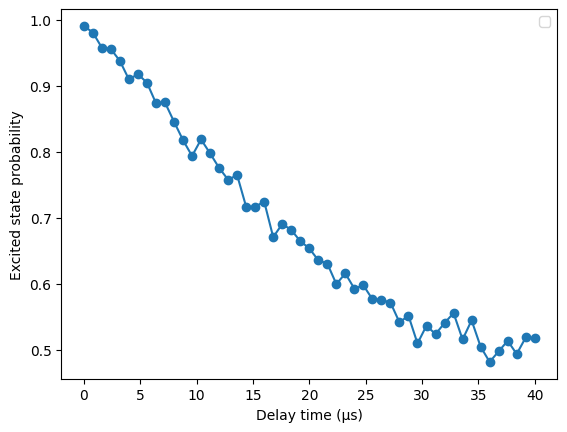

In [36]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

plt.figure()
x = time_axis * 1e6
y = np.array([circuit_result["M"][0][0] for circuit_result in job.result()])
plt.plot(x, 1-y, 'o-')
    
plt.xlabel("Delay time (µs)")
plt.ylabel("Excited state probability")
plt.legend();
plt.show()

In [19]:
# Copyright 2025 IQM Quantum Computers (Manish Thapa )
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.